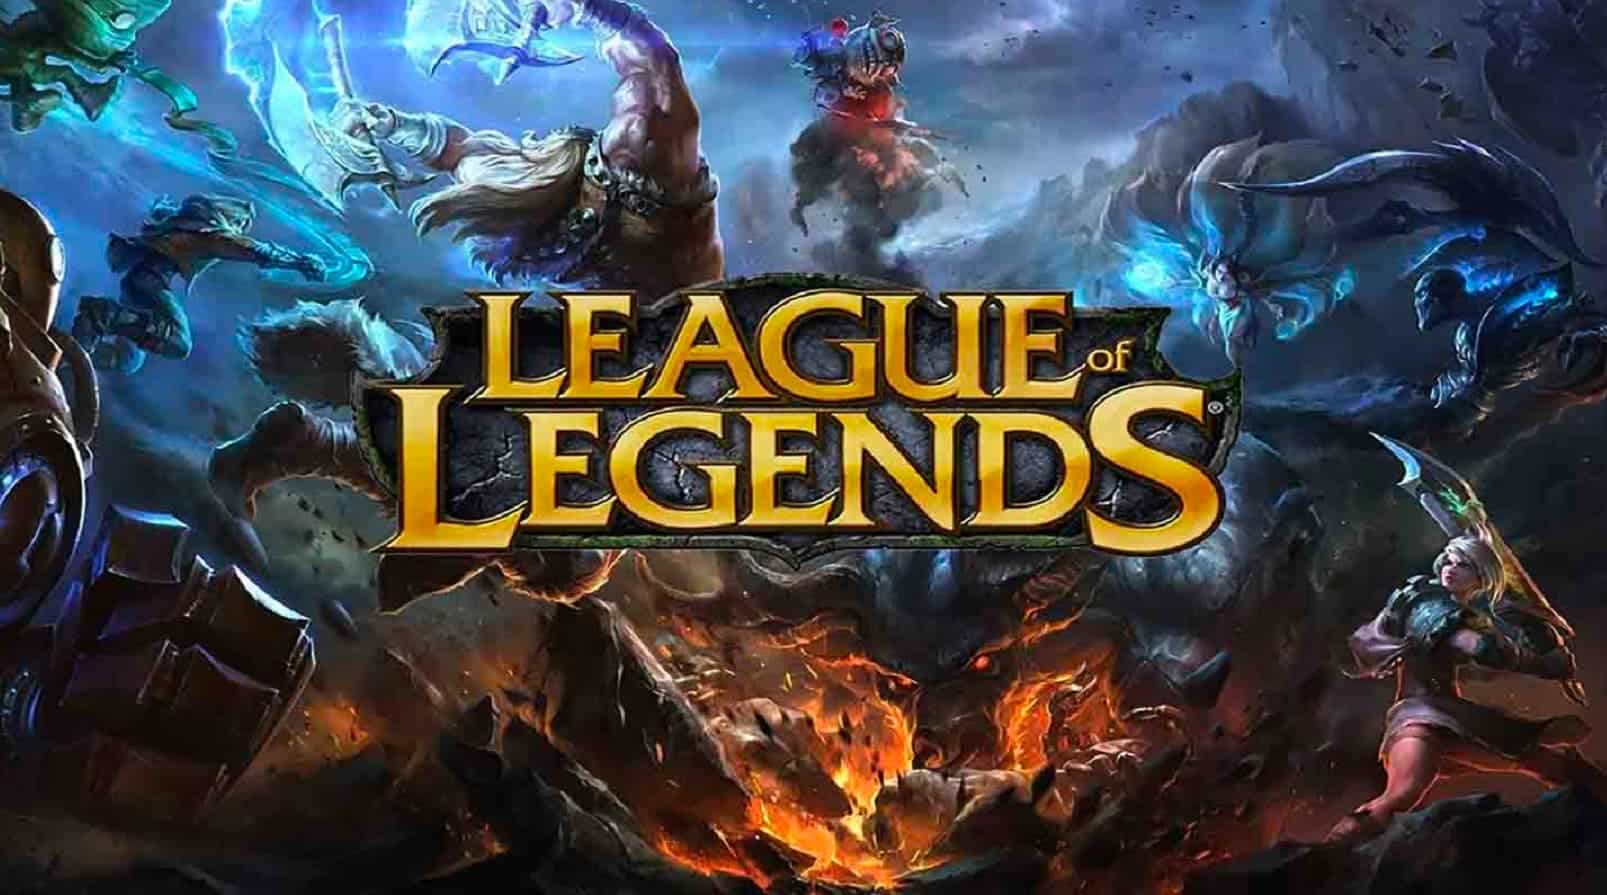

In [1]:
from IPython.display import Image
Image("other/league-of-legends.jpg")

### What is it?
League of Legends is one of the most popular multiplayers games today with over 115 milion users. The main idea is really simple. There are two teams each with five members. Your task is to destroy the enemy Nexus. To do that you need make your character as strong as possible. There are a lot of different roles in the team. You can be a tank, sorcerer, jungler, support or AD. The map consists of three lanes with towers.
### Data
This dataset contains the first 10min. stats of approx. 10k ranked games (SOLO QUEUE) from a high ELO (DIAMOND I to MASTER). Players have roughly the same level.

Each game is unique. The gameId can help you to fetch more attributes from the Riot API.

There are 19 features per team (38 in total) collected after 10min in-game. This includes kills, deaths, gold, experience, level… It's up to you to do some feature engineering to get more insights.

The column blueWins is the target value (the value we are trying to predict). A value of 1 means the blue team has won. 0 otherwise.

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

sns.set()

In [3]:
data_path = os.path.join('datasets', 'LeagueOfLegends', 'high_diamond_ranked_10min.csv')
df = pd.read_csv(data_path)
df.drop(columns=['gameId'], inplace=True)
print('Shape is ', df.shape)
df.head()

Shape is  (9879, 39)


,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,0,28,2,1,9,6,11,0,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,0,12,1,0,5,5,5,0,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,0,15,0,0,7,11,4,1,1,0,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,0,43,1,0,4,5,5,1,0,1,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,0,75,4,0,6,6,6,0,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [4]:
(df.isnull().sum() / df.count()).sum()

0.0

Great! There are no missing values.

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

There are a lot of columns that are not really useful. For example if we know th value of column **BlueKills** we don't need column **redDeaths** because there are almost always equal (you can be killed by minions). That's why I remove duplicated features. 

<AxesSubplot:>

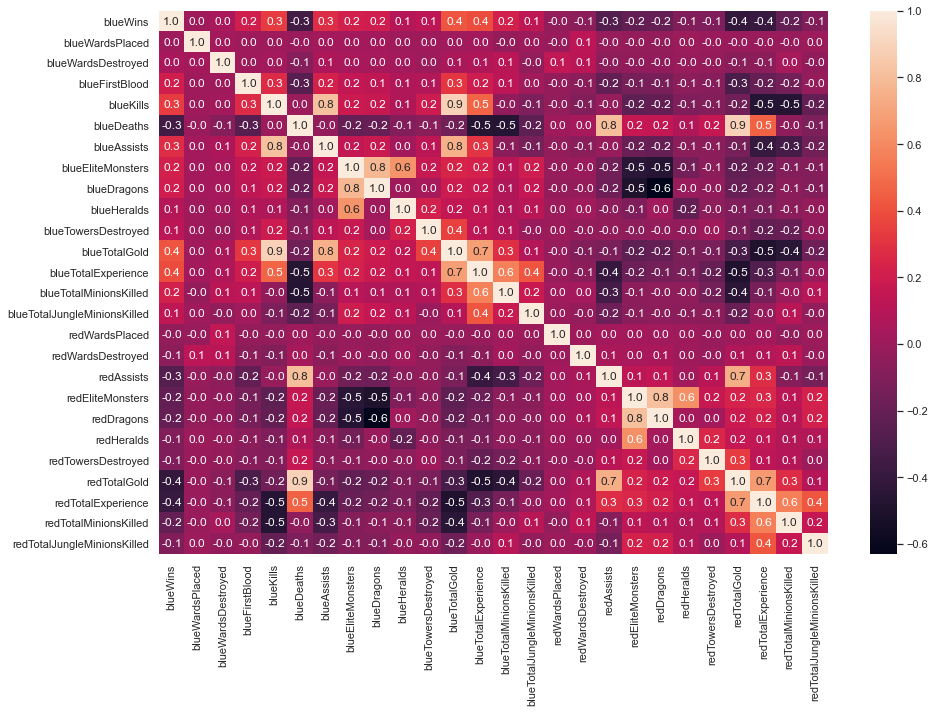

In [6]:
multicor_cols = ['redFirstBlood', 'redKills', 'redDeaths', 'redGoldDiff', 'redExperienceDiff', 
                 'redCSPerMin', 'redGoldPerMin', 'blueCSPerMin', 'blueGoldPerMin', 'redAvgLevel', 'blueAvgLevel', 
                 'blueGoldDiff', 'blueExperienceDiff']
train_df = train_df.drop(columns=multicor_cols)
test_df = test_df.drop(columns=multicor_cols)
corr_mat = train_df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_mat, annot=True, fmt='.1f')

There are no features strongly correlated with labes. It is no suprising since after 10 minutes it is really difficult to say who will win. Unfortunately it mean that achieving high accuracy will be extremely difficult.

<AxesSubplot:xlabel='blueWins', ylabel='blueTotalExperience'>

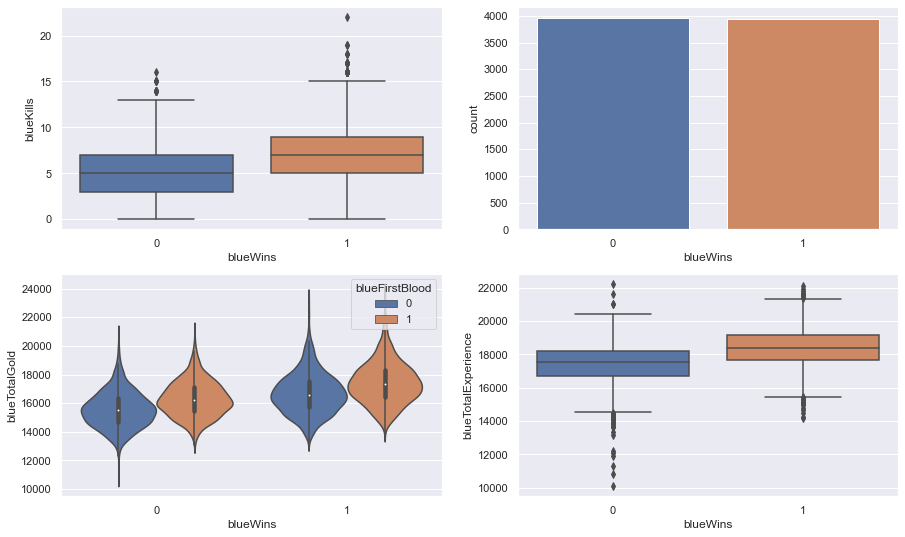

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 9))
ax1, ax2, ax3, ax4 = axes.flat
sns.boxplot(x='blueWins', y='blueKills', data=train_df, ax=ax1)
sns.countplot(x=train_df['blueWins'], ax=ax2)
sns.violinplot(y='blueTotalGold', x='blueWins', 
               hue='blueFirstBlood', data=train_df, 
               ax=ax3)
sns.boxplot(x='blueWins', y='blueTotalExperience', data=train_df, ax=ax4)

Number of wining and losing games for blue team is almost equal. Boxplots shows what is intuitive that If you gain more expericence and more kills probabilty of wining the game is higher. However relationship is not strong. Additionally having more gold is also good if you want be a winnner.

<AxesSubplot:xlabel='blueTotalExperience', ylabel='redTotalExperience'>

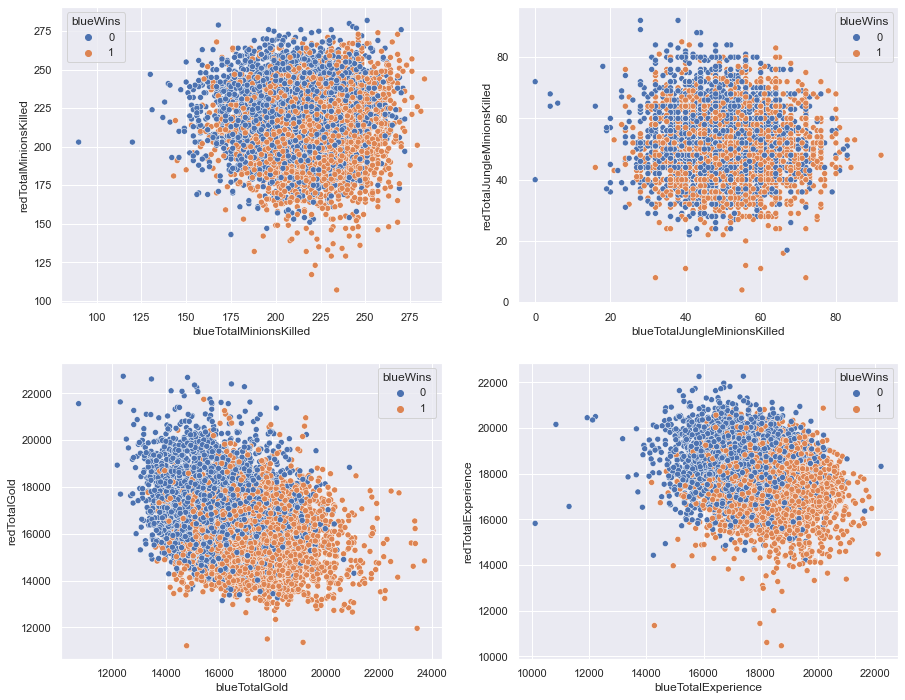

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
ax1, ax2, ax3, ax4 = axes.flat
sns.scatterplot(x='blueTotalMinionsKilled', y='redTotalMinionsKilled', 
                hue='blueWins', data=train_df, ax=ax1)
sns.scatterplot(x='blueTotalJungleMinionsKilled', y='redTotalJungleMinionsKilled', 
                hue='blueWins', data=train_df, ax=ax2)
sns.scatterplot(x='blueTotalGold', y='redTotalGold', 
                hue='blueWins', data=train_df, ax=ax3)
sns.scatterplot(x='blueTotalExperience', y='redTotalExperience', 
                hue='blueWins', data=train_df, ax=ax4)

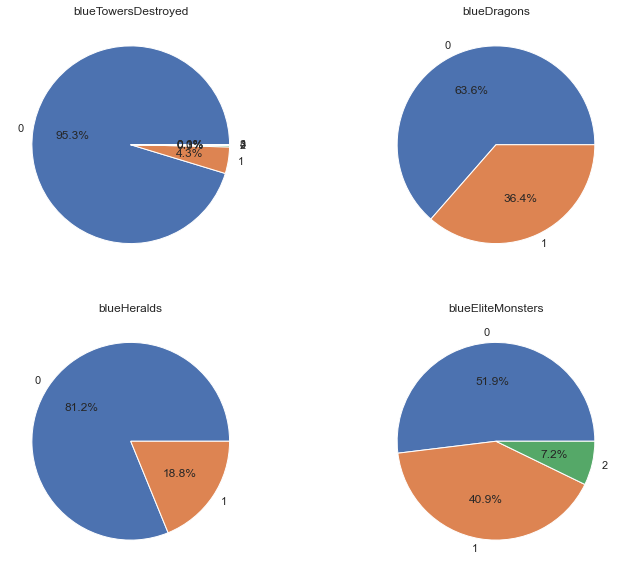

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
ax1, ax2, ax3, ax4 = axes.flat
cols = ['blueTowersDestroyed', 'blueDragons', 'blueHeralds', 'blueEliteMonsters']
for i, ax in enumerate(axes.flat):
    one_col = cols[i]
    labels = train_df[one_col].value_counts().index
    ax.pie(train_df[one_col].value_counts(), autopct='%1.1f%%', labels=labels)
    ax.set_title(one_col);

Machine Learning

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

In [ ]:
X_train = train_df.drop(columns='blueWins')
Y_train = train_df['blueWins']

**Logistic Regression**

In [42]:
lr_model = LogisticRegression(max_iter=1000,
                              tol=1e-6,
                              random_state=42)
lr_pipeline = make_pipeline(StandardScaler(), lr_model)
scores = cross_val_score(lr_pipeline, X_train, Y_train, cv=5)
np.mean(scores)

0.7314951280634753

**Gaussian Naive Bayes**

In [53]:
nb_model = GaussianNB(var_smoothing=1e-5)
scores = cross_val_score(nb_model, X_train, Y_train, cv=5)
np.mean(scores)

0.7242831407777484

**Decision Tree**

Text(0.5, 0, 'Max depth')

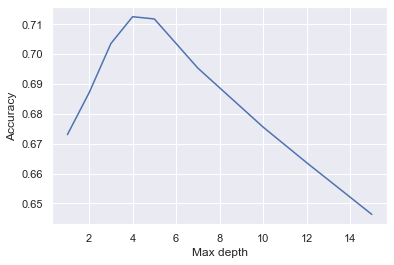

In [49]:
results = []
for depth in [1,2,3,4,5,7,10,12,15]:
    tree_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(tree_model, X_train, Y_train, cv=5)
    results.append((depth, np.mean(scores)))
results = np.array(results)
plt.plot(results[:, 0], results[:, 1])
plt.ylabel('Accuracy')
plt.xlabel('Max depth')

**K Nearest Neighbors**

Text(0.5, 0, 'Max depth')

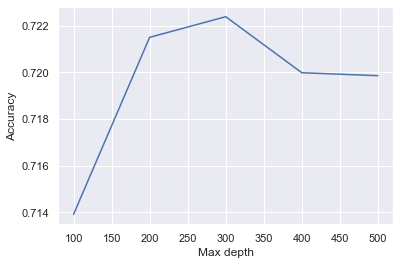

In [75]:
results = []
for k in [100, 200, 300, 400, 500]:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_pipeline = make_pipeline(StandardScaler(), knn_model)
    scores = cross_val_score(knn_pipeline, X_train, Y_train, cv=5)
    results.append((k, np.mean(scores)))
results = np.array(results)
plt.plot(results[:, 0], results[:, 1])
plt.ylabel('Accuracy')
plt.xlabel('Max depth') 

**PCA**

In [ ]:
pca = PCA(n_components=2)
pca_pipeline = make_pipeline(StandardScaler(), pca)